In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

In [20]:
from timeit import default_timer
start = default_timer()

In [3]:
movies = pd.read_csv('../Datasets/movies.csv')
ratings = pd.read_csv('../Datasets/ratings.csv')

In [4]:
movies.head(10)

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
5                        Action|Crime|Thriller  
6                               Comedy|Romance  
7                           Adventure|Children  
8                                       Action  
9                    Action|Adventure|Thriller

In [5]:
ratings.head(10)

userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510
5       1     1088     4.0  1147868495
6       1     1175     3.5  1147868826
7       1     1217     3.5  1147878326
8       1     1237     5.0  1147868839
9       1     1250     4.0  1147868414

In [6]:
# Organise a bit and store into feather-format
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [7]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

In [8]:
# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

In [9]:
# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

In [10]:
# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)

Number of movies Null values:  410
Number of ratings Null values:  0


In [11]:
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

In [12]:
# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies[['movieId', 'year']].groupby('year')

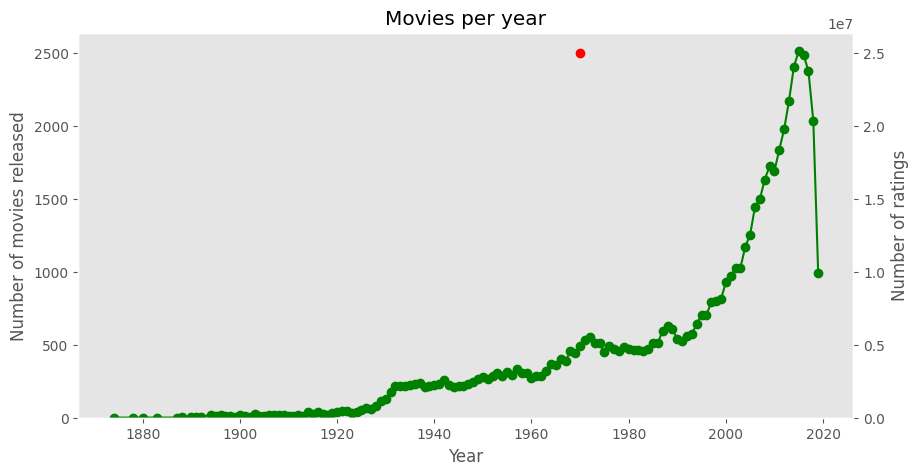

Elapsed time(sec):  2.08


In [22]:
st = default_timer()

# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

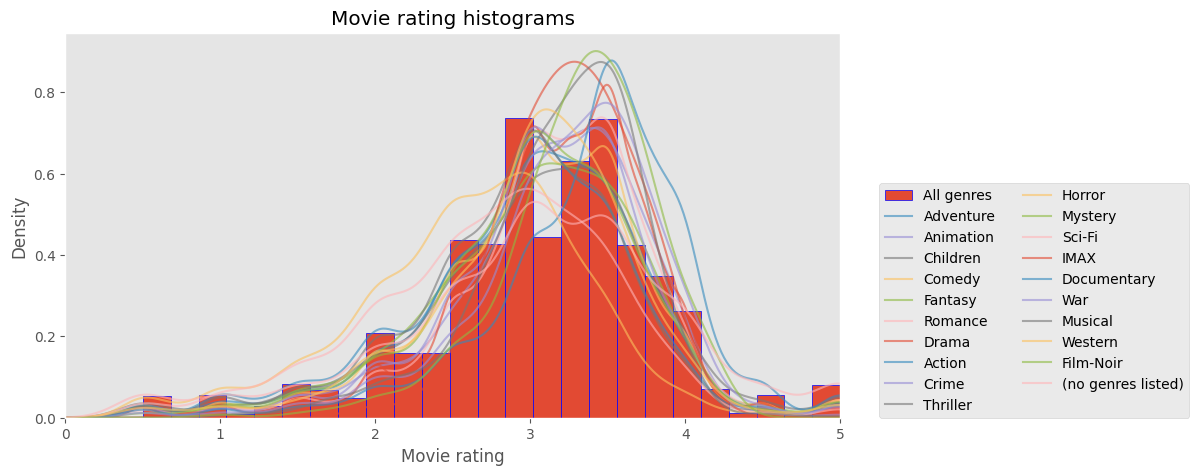

Elapsed time(sec):  26.34


In [25]:
st = default_timer()

dftmp = ratings[['movieId','rating']].groupby('movieId').mean()

# Initialize empty list to capture basic stats by gere
rating_stats = []
# Plot general histogram of all ratings
dftmp.hist(bins=25, grid=False, edgecolor='b', density=True, label ='All genres', figsize=(10,5))
# Plot histograms (kde lines for better visibility) per genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]==True]
    dftmp = ratings[ratings.set_index('movieId').index.isin(dftmp.set_index('movieId').index)]
    dftmp = dftmp[['movieId','rating']].groupby('movieId').mean()
    dftmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)
    avg = dftmp.rating.mean()
    std = dftmp.rating.std()
    rating_stats.append((genre, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

# Housekeeping
%reset_selective -f (^avg$|^dftmp$|^genre$|^std$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<Figure size 1000x500 with 0 Axes>

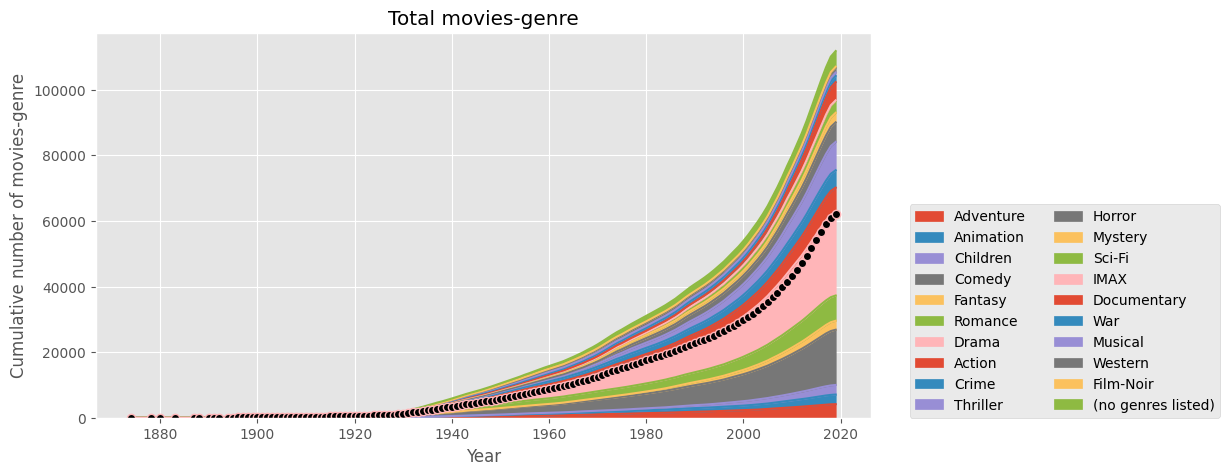

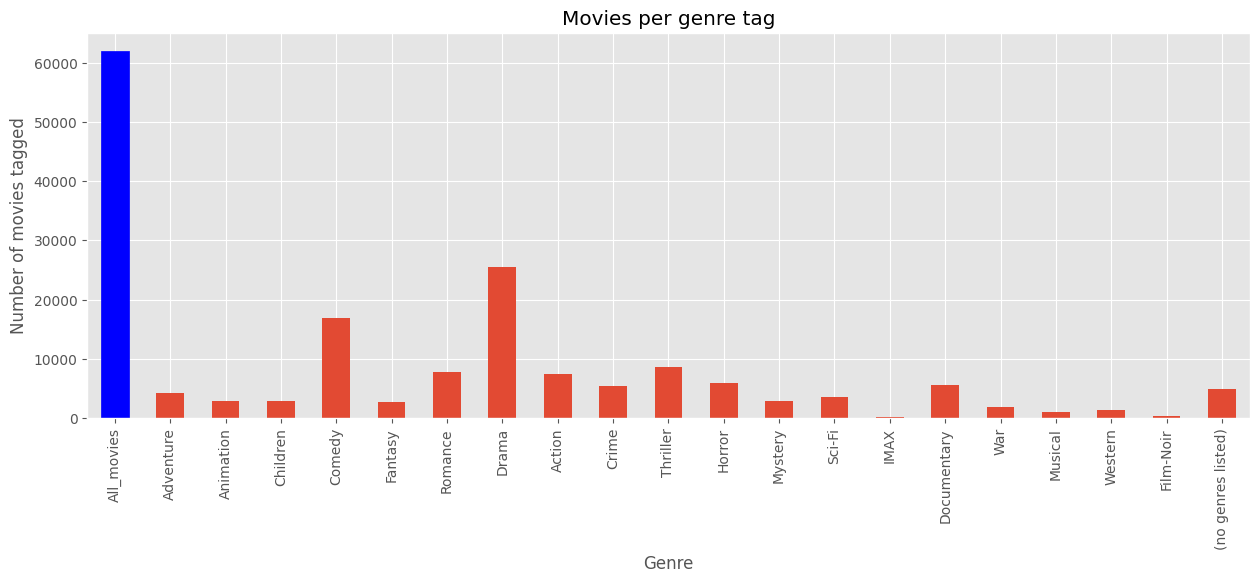

Elapsed time(sec):  1.62


In [21]:
st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})
# Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

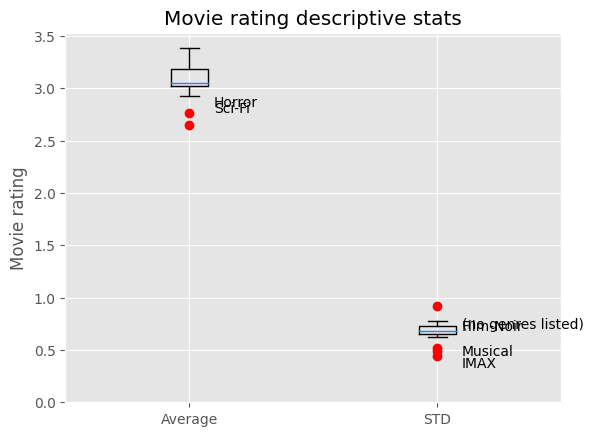

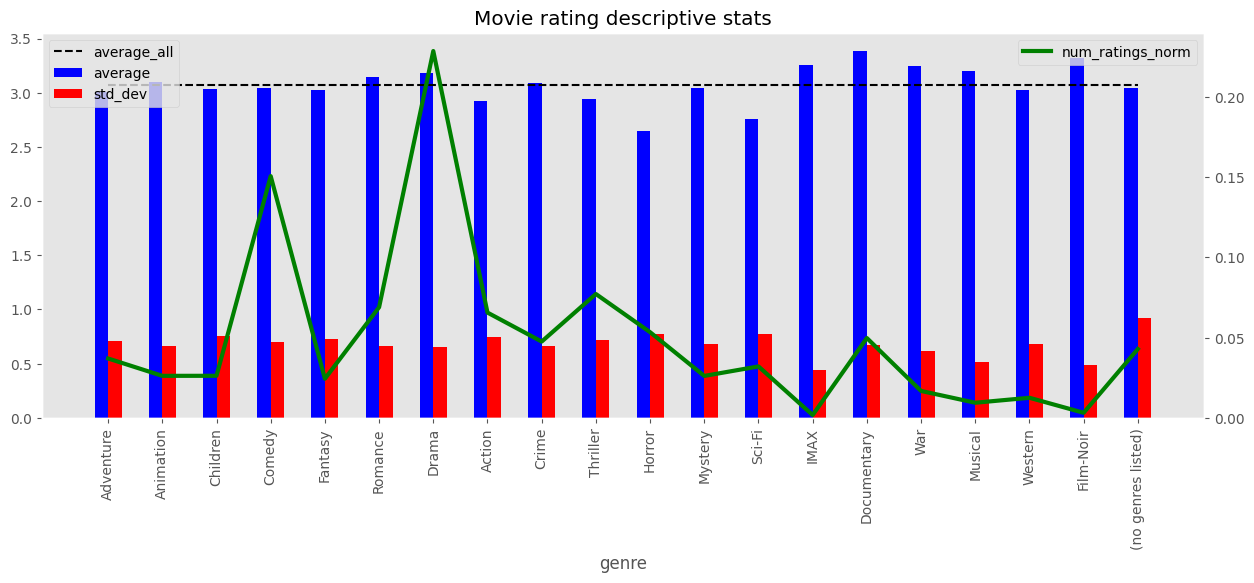

Outliers:  {'IMAX', 'Sci-Fi', 'Film-Noir', '(no genres listed)', 'Horror', 'Musical'}
genre             Adventure  Animation  Children    Comedy   Fantasy  \
average            3.010614   3.100958  3.032964  3.042291  3.022389   
std_dev            0.712576   0.665618  0.759474  0.699224  0.724313   
num_ratings_norm   0.036990   0.026177  0.026204  0.150642  0.024362   
average_all        3.071412   3.071412  3.071412  3.071412  3.071412   

genre              Romance     Drama    Action     Crime  Thriller    Horror  \
average           3.147334  3.178987  2.925590  3.092559  2.945069  2.650763   
std_dev           0.658632  0.650552  0.745305  0.660061  0.721586  0.775260   
num_ratings_norm  0.068935  0.228583  0.065599  0.047525  0.077190  0.053392   
average_all       3.071412  3.071412  3.071412  3.071412  3.071412  3.071412   

genre              Mystery    Sci-Fi      IMAX  Documentary       War  \
average           3.045802  2.761345  3.252121     3.383110  3.246515   
std_de

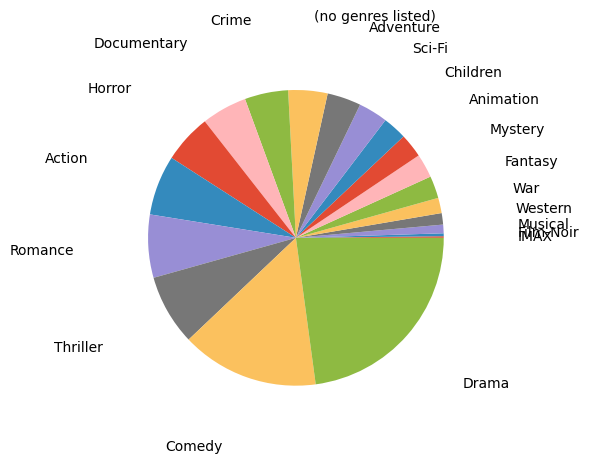

Elapsed time(sec):  1.62


In [30]:
st = default_timer()

# Construct a DataFrame with all the basic stats per genre
rating_sum = pd.DataFrame(rating_stats,  columns=['genre', 'average', 'std_dev'])
rating_sum.set_index('genre', inplace=True)
# Create a list of data arrays for boxplot
data_for_boxplot = [rating_sum['average'], rating_sum['std_dev']]

bxplot = plt.boxplot(data_for_boxplot, labels=['Average', 'STD'], sym="ro")
# Properly label the outliers
outliers = []
for i, value in enumerate(bxplot['fliers']):
    for val in value.get_ydata():
        bxplot_label = rating_sum.index[rating_sum.iloc[:, i] == val][0]
        outliers.append(bxplot_label)
        plt.annotate(bxplot_label, xy=(i+1.1, val+np.random.uniform(-0.25,0.25))) # Trick to prevent overlapping
outliers = set(outliers)
plt.ylim(0,)
plt.ylabel('Movie rating')
plt.title('Movie rating descriptive stats')
plt.show()

# Bar chart with average rating, standard deviation and normalized number of ratings per genre
# Calculate the normalized number of ratings per genre
rating_sum['num_ratings_norm']=df.iloc[-1, 1:]/df.iloc[-1, 1:].sum()
# Calculate the average rating for all genres
rating_sum['average_all']=rating_sum.average.mean()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

rating_sum[['average', 'std_dev']].plot(kind='bar', color=['b','r'], ax=ax, position=0.5, grid=False)
rating_sum['average_all'].plot(kind='line',style='--', color=['black'], ax=ax, grid=False)
rating_sum['num_ratings_norm'].plot(kind='line', color='g', ax=ax2, grid=False, linewidth=3)

ax.legend(loc=2)
ax2.legend(loc=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Movie rating descriptive stats')
plt.autoscale()
ax2.set_ylim(0,)
plt.show()

print("Outliers: ", outliers)
print(rating_sum.T)

# Quick pie chart to visualize how 3 genres take almost 50% of ratings
rating_sum.sort_values(by='num_ratings_norm', inplace=True)
plt.pie(rating_sum['num_ratings_norm'], labels=rating_sum.T.columns, labeldistance=1.5)
plt.show()


# Housekeeping
%reset_selective -f (^avg$|ax|bxplot|^df$|^dftmp$|^i$|^rating_stats$|^rating_sum$|^val$|^value$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

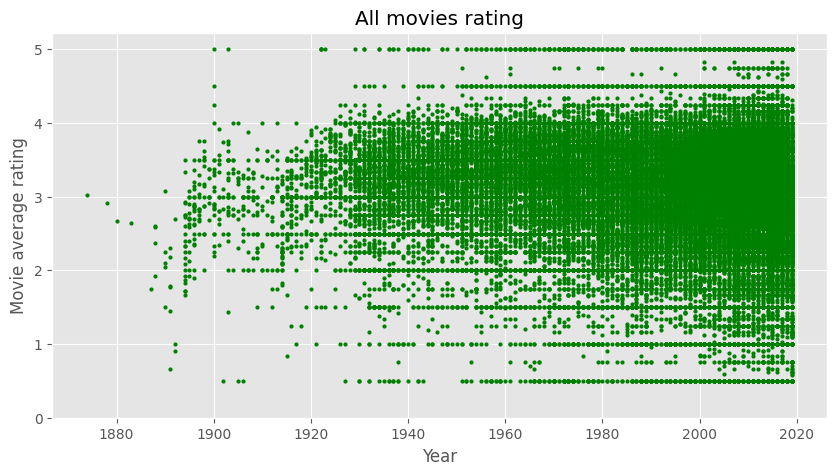

Elapsed time(sec):  1.58


In [31]:
st = default_timer()

dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Year')
plt.ylabel('Movie average rating')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

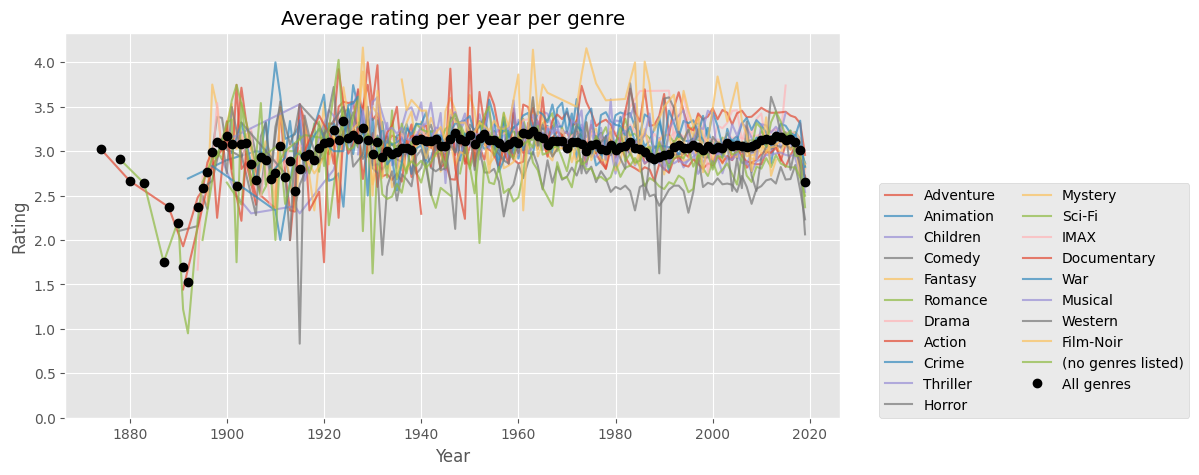

Elapsed time(sec):  24.55


In [32]:
st = default_timer()

plt.figure(figsize=(10,5))
# For each genre
for genre in genres_unique.genre:
    # Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    # Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

# For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='black')

plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year per genre')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

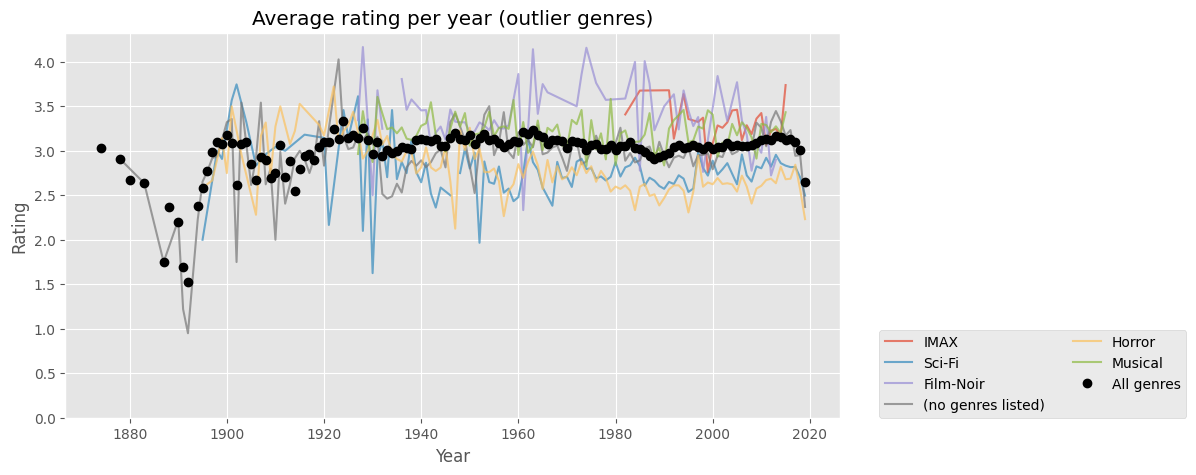

Elapsed time(sec):  9.31


In [33]:
st = default_timer()

plt.figure(figsize=(10,5))
for genre in outliers:
    # Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    # Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

# For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='black')
    
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year (outlier genres)')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$|^outliers$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

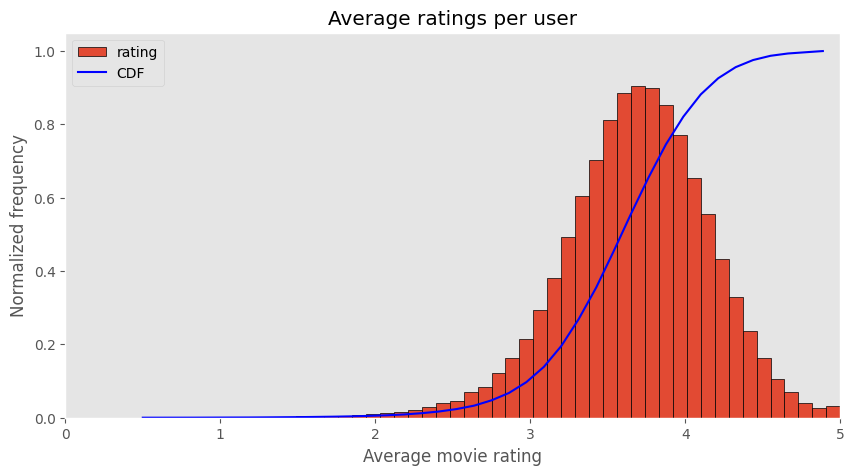

Elapsed time(sec):  4.29


In [37]:
st = default_timer()

dftmp = ratings[['userId','rating']].groupby('userId').mean()
# Plot histogram
dftmp.plot(kind='hist', bins=50, grid=0, density=True, edgecolor='black', figsize=(10,5))
# Plot cumulative function on top (couldn't do any other way)
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40, density=True)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average ratings per user')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^base$|^cumulative$|^values$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

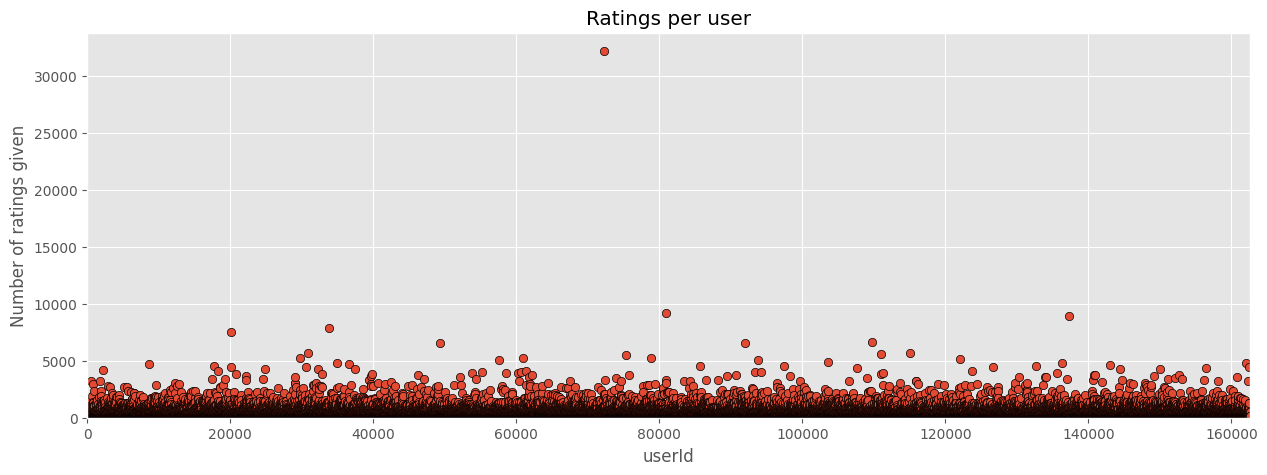

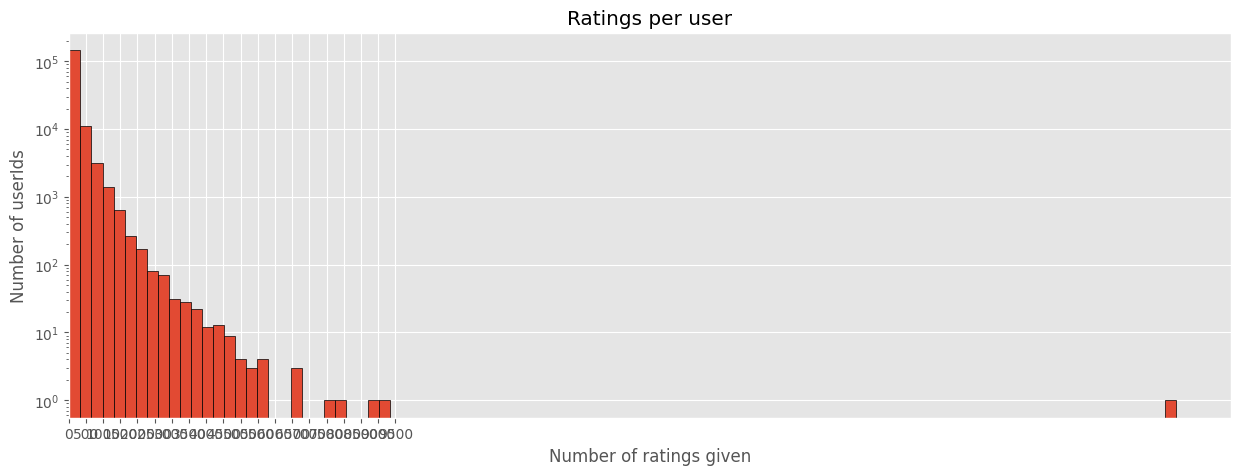

Elapsed time(sec):  4.83


In [42]:

st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,len(dftmp.index))
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per user')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of userIds')
plt.xlim(0,)
plt.xticks(np.arange(0,10000,500))
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

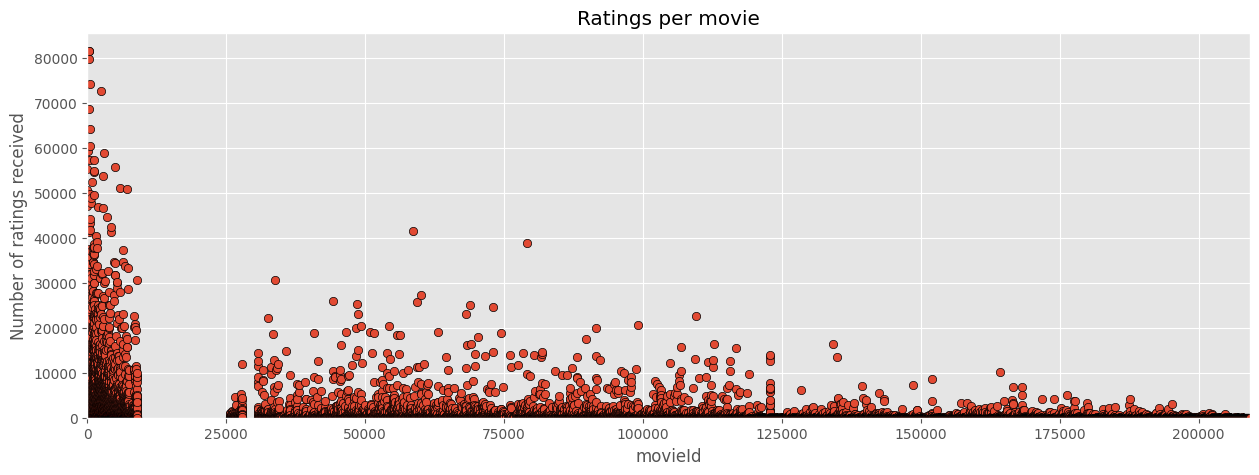

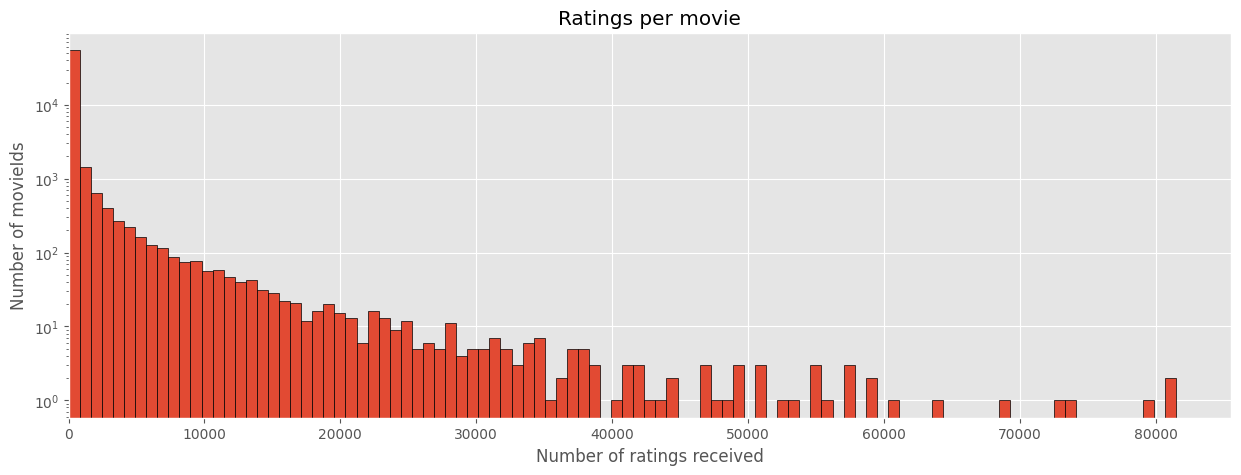

movieId
1                                                Toy Story
32                      Twelve Monkeys (a.k.a. 12 Monkeys)
47                                    Seven (a.k.a. Se7en)
50                                     Usual Suspects, The
110                                             Braveheart
150                                              Apollo 13
260                     Star Wars: Episode IV - A New Hope
296                                           Pulp Fiction
318                              Shawshank Redemption, The
356                                           Forrest Gump
364                                         Lion King, The
377                                                  Speed
380                                              True Lies
457                                          Fugitive, The
480                                          Jurassic Park
527                                       Schindler's List
588                                             

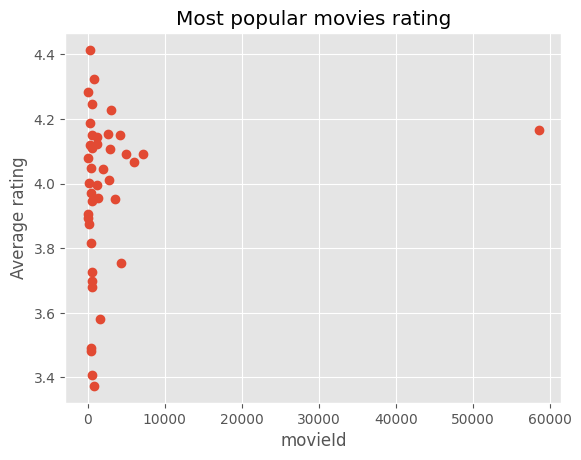

Best most popular movie ever is...Shawshank Redemption, The
Elapsed time(sec):  12.62


In [44]:
st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()

# Let's check those movies with +40k reviews, those should be pretty popular movies!
print(movies.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]]['title'])
# Let's check the average rating too, those should be pretty good movies!
ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean().rating.plot(style='o')
plt.ylabel('Average rating')
plt.title('Most popular movies rating')
plt.show()

# Which is the best most popular movie ever??
tmp = ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean()
# Convert the 'rating' column to numeric values
tmp['rating'] = pd.to_numeric(tmp['rating'])

# Now, you can find the maximum rating and its corresponding movie title
best = movies.set_index('movieId').loc[tmp['rating'].idxmax()].title
print ('Best most popular movie ever is...%s' %best)

# Housekeeping
%reset_selective -f (^dftmp$|^tmp$|^best$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [45]:
runtime = default_timer() - start
print ("Elapsed time(sec): ", round(runtime,2))

# Housekeeping
%reset_selective -f (^runtime$|^st$|^start$)

Elapsed time(sec):  1775.5


In [46]:
%whos

Variable             Type                          Data/Info
------------------------------------------------------------
NearestNeighbors     ABCMeta                       <class 'sklearn.neighbors<...>rvised.NearestNeighbors'>
RandomizedSearchCV   ABCMeta                       <class 'sklearn.model_sel<...>arch.RandomizedSearchCV'>
X                    ndarray                       1: 1 elems, type `int64`, 8 bytes
Xi                   ndarray                       135x1: 135 elems, type `int64`, 1080 bytes
Y                    ndarray                       135: 135 elems, type `float64`, 1080 bytes
Yi                   ndarray                       135x1: 135 elems, type `float64`, 1080 bytes
Z                    ndarray                       135: 135 elems, type `int64`, 1080 bytes
Zcap                 ndarray                       135: 135 elems, type `int64`, 1080 bytes
ax                   AxesSubplot                   AxesSubplot(0.125,0.53;0.352273x0.35)
axs                  n